In [1]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=d16ea5ecb230e9c8f086a8841a62ce94d1435b8de8ccb7c261b71d82f9faefca
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence_transformers


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import figure

In [3]:
np.random.seed(42)

In [8]:
#Read the Data

df_main = pd.read_csv('./classification_data.csv')
df_main.head()

,title,label
0,"Director, Learning and Support",CLASS1
1,Customer Service Assistant,CLASS2
2,2023 Internship and Education Program Manageme...,CLASS13
3,Communications Technician,CLASS13
4,Emergency Preparedness Officer,CLASS3


In [9]:
""" Data Pre-processing and Visualization  """ 

# check for null values

assert df_main.isnull().values.any() == False

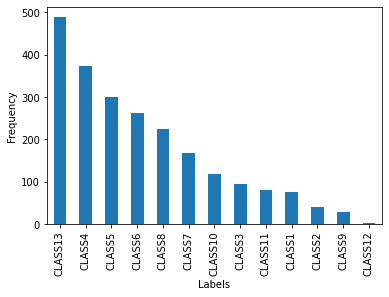

In [10]:
#class-wise distribution of data
fig, ax = plt.subplots()
df_main['label'].value_counts().plot(ax=ax, kind='bar')

ax.set_ylabel("Frequency")
ax.set_xlabel("Labels")
plt.show()

In [11]:
df_main['label'].value_counts()

CLASS13    489
CLASS4     373
CLASS5     300
CLASS6     263
CLASS8     225
CLASS7     168
CLASS10    119
CLASS3      94
CLASS11     81
CLASS1      76
CLASS2      40
CLASS9      28
CLASS12      3
Name: label, dtype: int64

In [12]:
# Remove non-encoding token, remove unnecessary tokens like -, comma, /,\ etc. numbers like 2023 and (1101l), lowercase the text
# can remove stop words like 'and', 'for' but not required!!


def pre_process(df_main,df_processed):
    df_processed['title'] = df_main['title'].apply(lambda x : re.sub(r'[^A-Za-z ]+', '', x))
    df_processed['title'] = df_processed['title'].apply(lambda x : " ".join(x.split()))
    df_processed['title'] = df_processed['title'].apply(lambda x : x.lower())
    df_processed['label'] = df_main['label'].apply(lambda x : int(x[5:]) )
    return df_processed

df_processed = pd.DataFrame()
df_processed = pre_process(df_main,df_processed)



In [13]:
df_processed.head()

,title,label
0,director learning and support,1
1,customer service assistant,2
2,internship and education program management in...,13
3,communications technician,13
4,emergency preparedness officer,3


In [14]:
def split_dataset(df_processed):
    
    df_class12 = df_processed[df_processed['label'] == 12]
    class12_index = df_class12.index
    
    df_processed = df_processed.drop(df_class12.index)
    
    X_train, X_test_temp , y_train, y_test_temp = train_test_split(df_processed['title'], df_processed['label'],
                                                    stratify=df_processed['label'], shuffle= True,
                                                    test_size=0.3)
    
    X_test, X_valid, y_test, y_valid = train_test_split(X_test_temp, y_test_temp,
                                                    stratify=y_test_temp, shuffle= True,
                                                    test_size=0.5)
    
    # handle the most underpresented class ---> class 12
    
    X_train = X_train.append(df_class12['title'][:2])
    y_train = y_train.append(df_class12['label'][:2])
    
    X_test = X_test.append(df_class12['title'][1:2])
    y_test = y_test.append(df_class12['label'][1:2])
    
    X_valid = X_valid.append(df_class12['title'][2:3])
    y_valid = y_valid.append(df_class12['label'][2:3])
    
    return X_train, X_test, X_valid , y_train, y_test, y_valid
    
    
X_train, X_test, X_valid, y_train, y_test, y_valid = split_dataset(df_processed)


<ipython-input-14-ab94d2c1a479>:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(df_class12['title'][:2])
<ipython-input-14-ab94d2c1a479>:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train = y_train.append(df_class12['label'][:2])
<ipython-input-14-ab94d2c1a479>:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(df_class12['title'][1:2])
<ipython-input-14-ab94d2c1a479>:22: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test = y_test.append(df_class12['label'][1:2])
<ipython-input-14-ab94d2c1a479>:24: FutureWarning: The series.append method is deprecated and will be removed from

In [15]:
# class 12(minority class) has only 3 samples
df_processed[df_processed['label']==12]

,title,label
1162,intraday power trading analyst,12
1637,trading efficiency lead,12
1638,trading change lead simplify,12


In [21]:
def sentence_pairs_generation(sentences, labels, pairs):

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  # print(idx)
  for k in range(5):
    for idxA in range(len(sentences)):      
      currentSentence = sentences[idxA]
      label = labels[idxA]
      idxB = np.random.choice(idx[np.where(numClassesList==label)[0][0]])
      posSentence = sentences[idxB]
        # prepare a positive pair and update the sentences and labels
        # lists, respectively
      pairs.append(InputExample(texts=[currentSentence, posSentence], label=1.0))

      negIdx = np.where(labels != label)[0]
      negSentence = sentences[np.random.choice(negIdx)]
        # prepare a negative pair of images and update our lists
      pairs.append(InputExample(texts=[currentSentence, negSentence], label=0.0))

    # Add more samples to negative class
    minor_class =[2,9,12]

    for i in minor_class:
      for j in range(200):
        idxB = np.random.choice(idx[np.where(numClassesList==i)[0][0]])
        minorSentence = sentences[idxB]
        negIdx = np.where(labels != i)[0]
        negSentence = sentences[np.random.choice(negIdx)]
        pairs.append(InputExample(texts=[minorSentence, negSentence], label=0.0))

  return (pairs)

In [22]:
train_examples = [] 

train_examples = sentence_pairs_generation(np.array(X_train), np.array(y_train), train_examples)


In [23]:
train_examples = [] 

train_examples = sentence_pairs_generation(np.array(X_train), np.array(y_train), train_examples)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=10, show_progress_bar=True)



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1176 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1176 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1176 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1176 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1176 [00:00<?, ?it/s]

In [26]:
#build a classifier on the sentence embeddings
X_train_encode = model.encode(np.array(X_train))

X_eval = model.encode(np.array(X_valid))

# balance is making confusion materix good. But overall accuracy goes down
svm =  SVC(kernel = 'rbf',class_weight = 'balanced')
svm.fit(X_train_encode, y_train)
y_pred_eval = svm.predict(X_eval)

print('Acc. Score', accuracy_score(y_valid, y_pred_eval))


Acc. Score 0.6676470588235294


In [27]:
#test accuracy
X_test = model.encode(np.array(X_test))
y_pred_test = svm.predict(X_test)

print('Acc. Score', accuracy_score(y_test, y_pred_test))

Acc. Score 0.6755162241887905


In [28]:
#classwise F1 score
f1_score(y_test, y_pred_test, average=None)

array([0.88      , 0.83333333, 0.72      , 0.7184466 , 0.72527473,
       0.78378378, 0.50746269, 0.57534247, 0.88888889, 0.73684211,
       0.37037037, 1.        , 0.65151515])

In [29]:
#confusion matrix
cf_matrix=confusion_matrix(y_test, y_pred_test)
cf_matrix

array([[11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  9,  0,  0,  0,  1,  0,  1,  1,  0,  0,  2],
       [ 0,  0,  1, 37,  7,  0,  2,  6,  0,  0,  2,  0,  1],
       [ 1,  0,  0,  3, 33,  2,  0,  2,  0,  0,  1,  0,  3],
       [ 0,  0,  0,  1,  3, 29,  2,  0,  0,  1,  0,  0,  3],
       [ 0,  0,  0,  0,  1,  0, 17,  2,  0,  1,  0,  0,  4],
       [ 0,  0,  0,  2,  1,  0,  7, 21,  0,  1,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  2,  0,  0, 14,  0,  0,  1],
       [ 0,  1,  0,  0,  1,  0,  1,  3,  0,  0,  5,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 1,  0,  0,  4,  0,  4, 10,  5,  0,  2,  4,  0, 43]])

<Axes: >

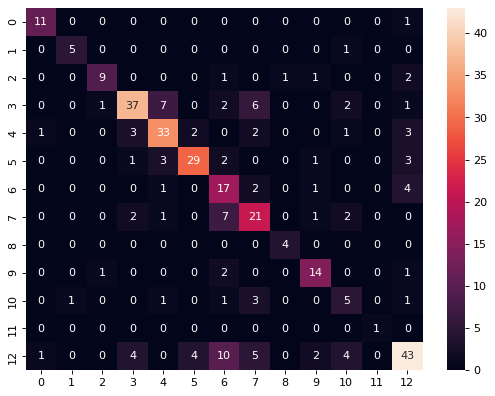

In [30]:
figure(figsize=(8, 6), dpi=80)
sns.heatmap(cf_matrix, annot=True)

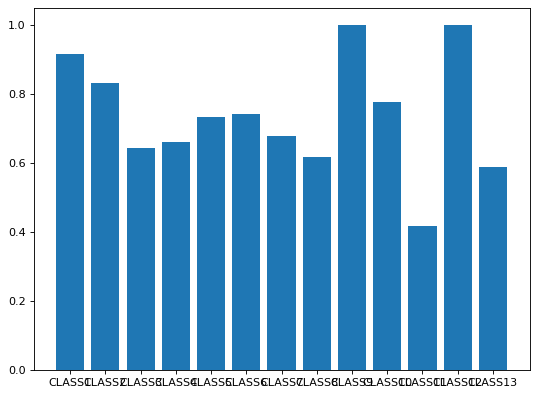

In [31]:
#classwise accuracy
class_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=1)

class_label = ['CLASS'+str(i+1) for i in range(13)]

figure(figsize=(8, 6), dpi=80)
plt.bar(class_label,class_acc)
plt.show()

In [32]:
classification_report(y_test, y_pred_test)

'              precision    recall  f1-score   support\n\n           1       0.85      0.92      0.88        12\n           2       0.83      0.83      0.83         6\n           3       0.82      0.64      0.72        14\n           4       0.79      0.66      0.72        56\n           5       0.72      0.73      0.73        45\n           6       0.83      0.74      0.78        39\n           7       0.40      0.68      0.51        25\n           8       0.54      0.62      0.58        34\n           9       0.80      1.00      0.89         4\n          10       0.70      0.78      0.74        18\n          11       0.33      0.42      0.37        12\n          12       1.00      1.00      1.00         1\n          13       0.73      0.59      0.65        73\n\n    accuracy                           0.68       339\n   macro avg       0.72      0.74      0.72       339\nweighted avg       0.70      0.68      0.68       339\n'